# KLASIFIKASI NAIVE BAYES

Klasifikasi menggunakan Naive Bayes dan random forest
1. Data belum diseimbangkan
2. Data diseimbangkan menggunakan smote
3. Data diseimbangkan menggunakan adasyn

Setelah di Klasifikasi, tambahkan Bagging classifier

## Import Libary

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import LabelEncoder


In [58]:
# Baca langsung dari file CSV
df = pd.read_csv("ecoli.csv")

print("Data awal:")
print(df.head())
print("\nInfo dataset:")
print(df.info())
print("\nJumlah data per kelas:")
print(df["class"].value_counts())

Data awal:
  sequence_name   mcg   gvh   lip  chg   aac  alm1  alm2 class
0     AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
1    ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
2    ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
3    ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp
4     ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35    cp

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sequence_name  336 non-null    object 
 1   mcg            336 non-null    float64
 2   gvh            336 non-null    float64
 3   lip            336 non-null    float64
 4   chg            336 non-null    float64
 5   aac            336 non-null    float64
 6   alm1           336 non-null    float64
 7   alm2           336 non-null    float64
 8   class          336 non-null    object 
dtypes: 

### Explorasi dan Distribusi Kelas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sequence_name  336 non-null    object 
 1   mcg            336 non-null    float64
 2   gvh            336 non-null    float64
 3   lip            336 non-null    float64
 4   chg            336 non-null    float64
 5   aac            336 non-null    float64
 6   alm1           336 non-null    float64
 7   alm2           336 non-null    float64
 8   class          336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB



/tmp/ipython-input-209290213.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="class", palette="Set2", order=df["class"].value_counts().index)


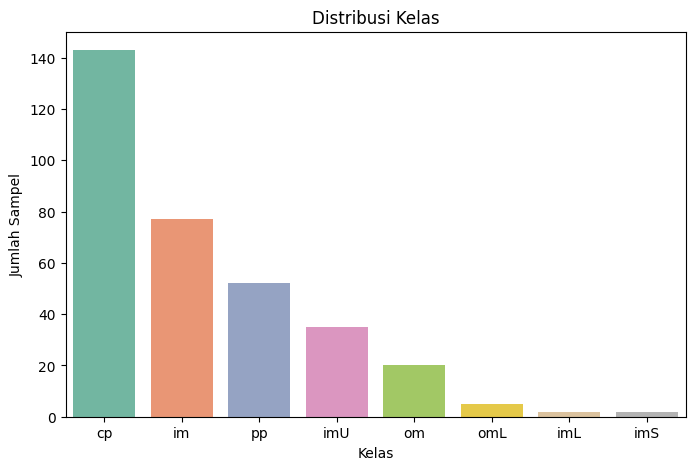


=== Distribusi Kelas ===
class
cp     143
im      77
pp      52
imU     35
om      20
omL      5
imL      2
imS      2
Name: count, dtype: int64


In [59]:
# Lihat info dasar
df_info = df.info()
df_head = df.head()
print("")
# Distribusi kelas
class_distribution = df['class'].value_counts()

df_head, class_distribution

plt.figure(figsize=(8,5))
sns.countplot(data=df, x="class", palette="Set2", order=df["class"].value_counts().index)
plt.title("Distribusi Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.show()

print("\n=== Distribusi Kelas ===")
print(df["class"].value_counts())

### Persiapan Data

In [60]:
# === 1. Pisahkan fitur & target ===
df_features = df.drop(columns=["sequence_name", "class"])
X = df.drop(columns=["sequence_name", "class"])  # hanya ambil fitur numerik
y = df["class"]  # target label

print("Shape fitur (X):", X.shape)
print("Shape target (y):", y.shape)

# === 2. Cek missing values ===
print("\nJumlah missing values tiap kolom:")
print(X.isnull().sum())

Shape fitur (X): (336, 7)
Shape target (y): (336,)

Jumlah missing values tiap kolom:
mcg     0
gvh     0
lip     0
chg     0
aac     0
alm1    0
alm2    0
dtype: int64


Shape X: (336, 7)
Shape y: (336,)


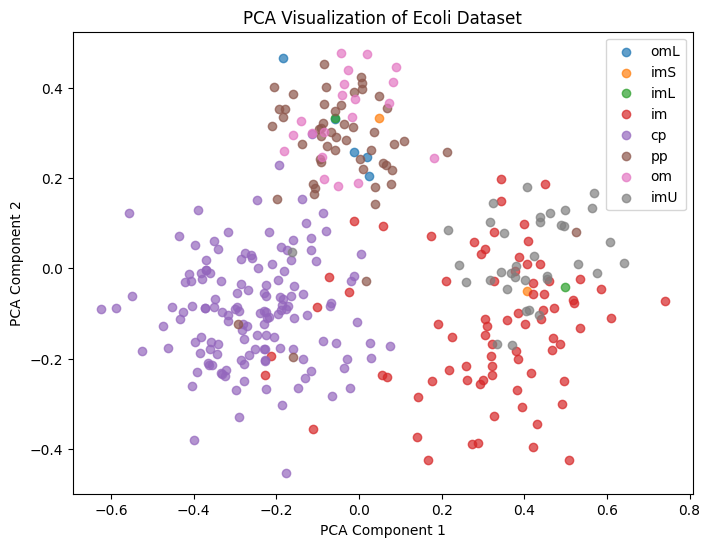

In [61]:
# X = fitur numerik, y = label
X = df_features.values
y = df["class"].values

print("Shape X:", X.shape)
print("Shape y:", y.shape)

# PCA ke 2 dimensi
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot hasil PCA
plt.figure(figsize=(8,6))
for label in set(y):
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        label=label,
        alpha=0.7
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Ecoli Dataset")
plt.legend()
plt.show()

## 1. **Eksperimen 1 – Data Belum Diseimbangkan**




### **Naive Bayes – Data Belum Diseimbangkan**

Pada tahap ini, kita menggunakan **Naive Bayes (GaussianNB)** untuk melakukan klasifikasi pada dataset asli *tanpa penyeimbangan kelas*.  
Langkah-langkah:
1. Pisahkan data menjadi training dan testing (80:20, stratified).
2. Latih model Naive Bayes pada data training.
3. Evaluasi model dengan data testing menggunakan akurasi, classification report, dan confusion matrix.

In [62]:
# Pisahkan data (belum seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inisialisasi model Naive Bayes
nb = GaussianNB()

# Latih model
nb.fit(X_train, y_train)

# Prediksi data uji
y_pred = nb.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Naive Bayes (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Naive Bayes (data asli): 0.7941176470588235

Classification Report:
               precision    recall  f1-score   support

          cp       0.97      1.00      0.98        29
          im       1.00      0.44      0.61        16
         imU       0.50      0.86      0.63         7
          om       0.00      0.00      0.00         4
         omL       1.00      1.00      1.00         1
          pp       0.61      1.00      0.76        11

    accuracy                           0.79        68
   macro avg       0.68      0.72      0.66        68
weighted avg       0.81      0.79      0.76        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 1  7  6  0  0  2]
 [ 0  0  6  0  0  1]
 [ 0  0  0  0  0  4]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0 11]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### **Random Forest – Data Belum Diseimbangkan**

Pada tahap ini, kita menggunakan **Random Forest Classifier** untuk melakukan klasifikasi pada dataset asli *tanpa penyeimbangan kelas*.  
Langkah-langkah:
1. Pisahkan data menjadi training dan testing (80:20, stratified).
2. Latih model Random Forest pada data training.
3. Evaluasi model dengan data testing menggunakan akurasi, classification report, dan confusion matrix.


In [63]:
# Pisahkan data (belum seimbang)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,      # jumlah pohon
    random_state=42,
    class_weight=None      # karena data belum seimbang, kita biarkan default
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi data uji
y_pred = rf.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Random Forest (data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Random Forest (data asli): 0.8676470588235294

Classification Report:
               precision    recall  f1-score   support

          cp       0.94      1.00      0.97        29
          im       0.91      0.62      0.74        16
         imU       0.50      0.86      0.63         7
          om       1.00      1.00      1.00         4
         omL       1.00      1.00      1.00         1
          pp       1.00      0.82      0.90        11

    accuracy                           0.87        68
   macro avg       0.89      0.88      0.87        68
weighted avg       0.90      0.87      0.87        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 0 10  6  0  0  0]
 [ 0  1  6  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 2  0  0  0  0  9]]


### **Bagging Classifier – Data Belum Diseimbangkan**

Pada tahap ini, kita menggunakan **Bagging Classifier** untuk melakukan klasifikasi pada dataset asli *tanpa penyeimbangan kelas*.  
Bagging akan dilatih dengan dua skenario:
1. Menggunakan **Naive Bayes** sebagai base estimator.
2. Menggunakan **Decision Tree** sebagai base estimator (default yang paling sering digunakan).  

Langkah-langkah:
1. Pisahkan data menjadi training dan testing (80:20, stratified).
2. Latih model Bagging dengan base estimator yang dipilih.
3. Evaluasi model menggunakan akurasi, classification report, dan confusion matrix.


#### Bagging dengan Naive Bayes

In [64]:
# Base estimator = Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=100,
    random_state=42
)

# Latih model
bag_nb.fit(X_train, y_train)

# Prediksi
y_pred = bag_nb.predict(X_test)

# Evaluasi
print("🔹 Akurasi Bagging (base Naive Bayes, data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (base Naive Bayes, data asli): 0.9117647058823529

Classification Report:
               precision    recall  f1-score   support

          cp       0.97      1.00      0.98        29
          im       1.00      0.69      0.81        16
         imU       0.67      0.86      0.75         7
          om       1.00      1.00      1.00         4
         omL       1.00      1.00      1.00         1
          pp       0.85      1.00      0.92        11

    accuracy                           0.91        68
   macro avg       0.91      0.92      0.91        68
weighted avg       0.93      0.91      0.91        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 1 11  3  0  0  1]
 [ 0  0  6  0  0  1]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0 11]]


/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naiv

#### Bagging dengan Decision Tree

In [65]:
# Base estimator = Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

# Latih model
bag_dt.fit(X_train, y_train)

# Prediksi
y_pred = bag_dt.predict(X_test)

# Evaluasi
print("🔹 Akurasi Bagging (base Decision Tree, data asli):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (base Decision Tree, data asli): 0.8382352941176471

Classification Report:
               precision    recall  f1-score   support

          cp       0.94      1.00      0.97        29
          im       0.83      0.62      0.71        16
         imU       0.42      0.71      0.53         7
          om       1.00      1.00      1.00         4
         omL       1.00      1.00      1.00         1
          pp       1.00      0.73      0.84        11

    accuracy                           0.84        68
   macro avg       0.86      0.84      0.84        68
weighted avg       0.87      0.84      0.84        68


Confusion Matrix:
 [[29  0  0  0  0  0]
 [ 0 10  6  0  0  0]
 [ 0  2  5  0  0  0]
 [ 0  0  0  4  0  0]
 [ 0  0  0  0  1  0]
 [ 2  0  1  0  0  8]]


## **Eksperimen 2 – Data Seimbang dengan SMOTE**

Pada eksperimen kedua, dataset yang sebelumnya tidak seimbang akan diseimbangkan menggunakan **SMOTE (Synthetic Minority Oversampling Technique)**.  
SMOTE bekerja dengan cara membuat data sintetis baru untuk kelas minoritas berdasarkan interpolasi antar tetangga terdekat.  

Langkah-langkah:
1. Terapkan SMOTE pada data asli.
2. Periksa kembali distribusi kelas setelah SMOTE.
3. Simpan data hasil balancing untuk digunakan pada klasifikasi berikutnya (Naive Bayes, Random Forest, Bagging).


In [66]:
# Terapkan SMOTE
smote = SMOTE(k_neighbors=1 ,random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

print("Distribusi sebelum SMOTE:", Counter(y))
print("Distribusi sesudah SMOTE:", Counter(y_sm))


Distribusi sebelum SMOTE: Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imS': 2, 'imL': 2})
Distribusi sesudah SMOTE: Counter({'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143})


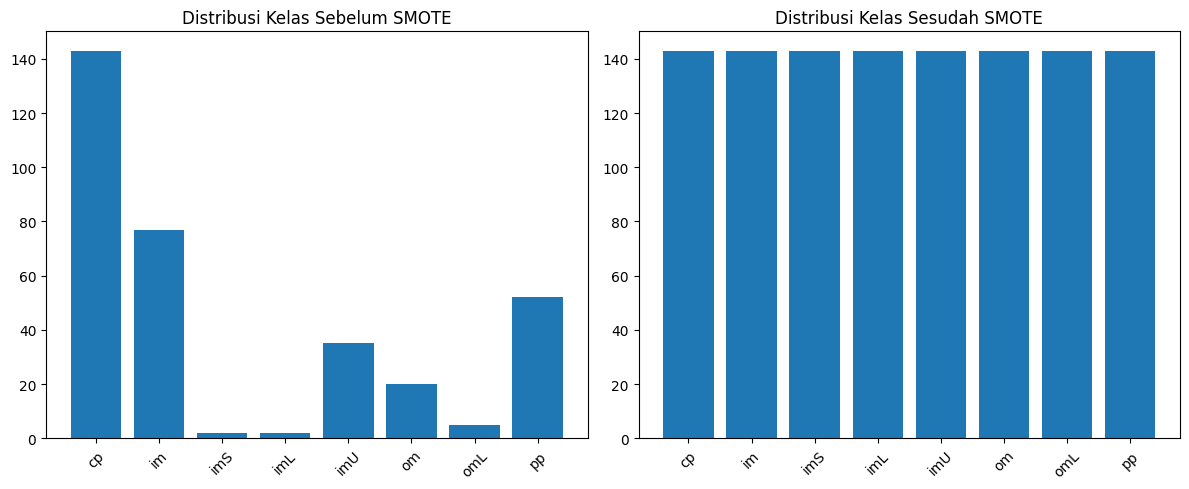

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Sebelum SMOTE
axes[0].bar(Counter(y).keys(), Counter(y).values())
axes[0].set_title("Distribusi Kelas Sebelum SMOTE")
axes[0].tick_params(axis='x', rotation=45)

# Sesudah SMOTE
axes[1].bar(Counter(y_sm).keys(), Counter(y_sm).values())
axes[1].set_title("Distribusi Kelas Sesudah SMOTE")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()




### PCA dengan SMOTE

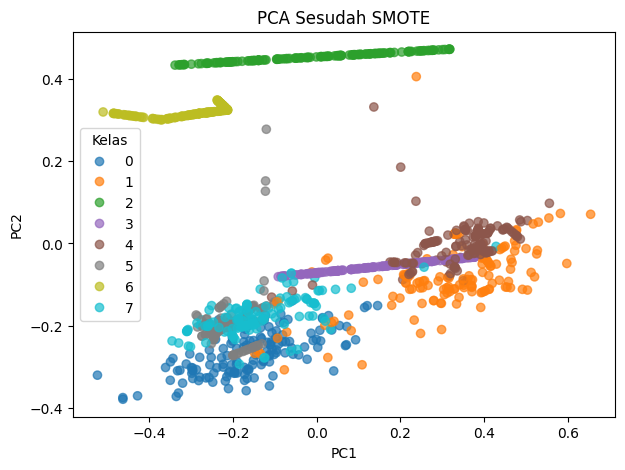

In [68]:
from sklearn.preprocessing import LabelEncoder

# Encode label kategori jadi angka
le = LabelEncoder()
y_sm_encoded = le.fit_transform(y_sm)

# Lakukan PCA ke 2 dimensi
pca = PCA(n_components=2, random_state=42)
X_sm_pca = pca.fit_transform(X_sm)

# Plot hasil PCA sesudah SMOTE
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_sm_pca[:, 0],
    X_sm_pca[:, 1],
    c=y_sm_encoded, cmap="tab10", alpha=0.7
)

# Buat legenda otomatis
plt.legend(
    *scatter.legend_elements(),
    title="Kelas"
)

plt.title("PCA Sesudah SMOTE")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


### **Naive Bayes – Data Seimbang (SMOTE)**

Setelah dataset diseimbangkan menggunakan **SMOTE**, model **Naive Bayes (GaussianNB)** digunakan kembali untuk klasifikasi.  
Langkah-langkah:
1. Bagi dataset hasil SMOTE menjadi data latih (train) dan data uji (test).
2. Latih model Naive Bayes pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [69]:
# Split data SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

# Inisialisasi Naive Bayes dengan smoothing
nb = GaussianNB(var_smoothing=1e-8)

# Latih model
nb.fit(X_train, y_train)

# Prediksi data uji
y_pred = nb.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Naive Bayes (SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Naive Bayes (SMOTE): 0.8646288209606987

Classification Report:
               precision    recall  f1-score   support

          cp       0.80      1.00      0.89        28
          im       1.00      0.50      0.67        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.81      0.86      0.83        29
          om       1.00      0.61      0.76        28
         omL       1.00      1.00      1.00        29
          pp       0.60      0.93      0.73        29

    accuracy                           0.86       229
   macro avg       0.90      0.86      0.86       229
weighted avg       0.90      0.86      0.86       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 5 14  0  0  6  0  0  3]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  0  0  0 25  0  0  4]
 [ 0  0  0  0  0 17  0 11]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


### **Random Forest – Data Seimbang (SMOTE)**

Setelah dataset diseimbangkan menggunakan **SMOTE**, model **Random Forest Classifier** digunakan untuk klasifikasi.  
Langkah-langkah:
1. Bagi dataset hasil SMOTE menjadi data latih (train) dan data uji (test).
2. Latih model Random Forest pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [70]:
# Split data SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi data uji
y_pred = rf.predict(X_test)

# Evaluasi hasil
print("🔹 Akurasi Random Forest (SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Random Forest (SMOTE): 0.9519650655021834

Classification Report:
               precision    recall  f1-score   support

          cp       0.88      1.00      0.93        28
          im       0.89      0.86      0.87        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.89      0.86      0.88        29
          om       1.00      0.96      0.98        28
         omL       1.00      1.00      1.00        29
          pp       0.96      0.93      0.95        29

    accuracy                           0.95       229
   macro avg       0.95      0.95      0.95       229
weighted avg       0.95      0.95      0.95       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 1 24  0  0  3  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 1  3  0  0 25  0  0  0]
 [ 0  0  0  0  0 27  0  1]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


### **Bagging Classifier – Data Seimbang (SMOTE)**

Setelah dataset diseimbangkan menggunakan **SMOTE**, model **Bagging Classifier** digunakan untuk klasifikasi.  
Dua skenario diuji:
1. Bagging dengan **Naive Bayes** sebagai base estimator.
2. Bagging dengan **Decision Tree** sebagai base estimator.  

Langkah-langkah:
1. Bagi dataset hasil SMOTE menjadi data latih (train) dan data uji (test).
2. Latih model Bagging dengan estimator terpilih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


#### Bagging dengan Naive Bayes

In [71]:
# Bagging dengan Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(var_smoothing=1e-8),
    n_estimators=100,
    random_state=42
)

bag_nb.fit(X_train, y_train)
y_pred = bag_nb.predict(X_test)

print("🔹 Akurasi Bagging (Naive Bayes, SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Naive Bayes, SMOTE): 0.8733624454148472

Classification Report:
               precision    recall  f1-score   support

          cp       0.82      1.00      0.90        28
          im       0.82      0.64      0.72        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.85      0.76      0.80        29
          om       1.00      0.64      0.78        28
         omL       1.00      1.00      1.00        29
          pp       0.64      0.93      0.76        29

    accuracy                           0.87       229
   macro avg       0.89      0.87      0.87       229
weighted avg       0.89      0.87      0.87       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 4 18  0  0  4  0  0  2]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 0  4  0  0 22  0  0  3]
 [ 0  0  0  0  0 18  0 10]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  0  0 27]]


#### Bagging dengan Decision Tree

In [72]:
# Bagging dengan Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

bag_dt.fit(X_train, y_train)
y_pred = bag_dt.predict(X_test)

print("🔹 Akurasi Bagging (Decision Tree, SMOTE):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Decision Tree, SMOTE): 0.9432314410480349

Classification Report:
               precision    recall  f1-score   support

          cp       0.85      1.00      0.92        28
          im       0.92      0.82      0.87        28
         imL       1.00      1.00      1.00        29
         imS       1.00      1.00      1.00        29
         imU       0.86      0.86      0.86        29
          om       0.96      0.96      0.96        28
         omL       1.00      1.00      1.00        29
          pp       0.96      0.90      0.93        29

    accuracy                           0.94       229
   macro avg       0.94      0.94      0.94       229
weighted avg       0.95      0.94      0.94       229


Confusion Matrix:
 [[28  0  0  0  0  0  0  0]
 [ 1 23  0  0  4  0  0  0]
 [ 0  0 29  0  0  0  0  0]
 [ 0  0  0 29  0  0  0  0]
 [ 2  2  0  0 25  0  0  0]
 [ 0  0  0  0  0 27  0  1]
 [ 0  0  0  0  0  0 29  0]
 [ 2  0  0  0  0  1  0 26]]


## **3. Eksperimen 3 – ADASYN**

Pada eksperimen ini digunakan teknik **ADASYN (Adaptive Synthetic Sampling)** untuk menyeimbangkan data.  
Langkah-langkah:
1. Pisahkan fitur (X) dan label (y).
2. Terapkan ADASYN dengan variasi parameter `n_neighbors` sesuai distribusi kelas.
3. Simpan hasil akhir dataset seimbang untuk digunakan dalam klasifikasi (Naive Bayes, Random Forest, dan Bagging).
4. Tampilkan distribusi kelas sebelum dan sesudah ADASYN.


In [73]:
naive_bayes = df
X = naive_bayes.drop(columns=["class", "sequence_name"])  # fitur numerik
y = naive_bayes["class"]

print("\nDistribusi kelas awal:")
print(sorted(Counter(y).items()))

class_counts = [count for _, count in Counter(y).items()]
temp = sorted(class_counts)

nt, ns = X, y  # salin awal
print(f"\nSorted counts untuk iterasi: {temp}")

for i in range(0, min(7, len(temp))):
    n = max(1, temp[i] - 1)  # n_neighbors tidak boleh < 1
    # print(f"\nIterasi {i+1}: menggunakan k_neighbors={n}")

    try:
        sampler = ADASYN(n_neighbors=n, sampling_strategy='minority', random_state=42)
        nt, ns = sampler.fit_resample(nt, ns)
        # print(f"Hasil iterasi {i+1}: {sorted(Counter(ns).items())}")
    except Exception as e:
        print(f"Error pada iterasi {i+1}: {e}")
        break

# ==========================
# 4. Hasil akhir
# ==========================
print(f"\nDistribusi kelas setelah ADASYN:")
print(f"{sorted(Counter(ns).items())}")

print(f"\nTotal samples sebelum: {len(y)}")
print(f"Total samples setelah: {len(ns)}")
print(f"Data yang ditambahkan: {len(ns) - len(y)}")



Distribusi kelas awal:
[('cp', 143), ('im', 77), ('imL', 2), ('imS', 2), ('imU', 35), ('om', 20), ('omL', 5), ('pp', 52)]

Sorted counts untuk iterasi: [2, 2, 5, 20, 35, 52, 77, 143]

Distribusi kelas setelah ADASYN:
[('cp', 143), ('im', 154), ('imL', 142), ('imS', 142), ('imU', 146), ('om', 143), ('omL', 143), ('pp', 143)]

Total samples sebelum: 336
Total samples setelah: 1156
Data yang ditambahkan: 820


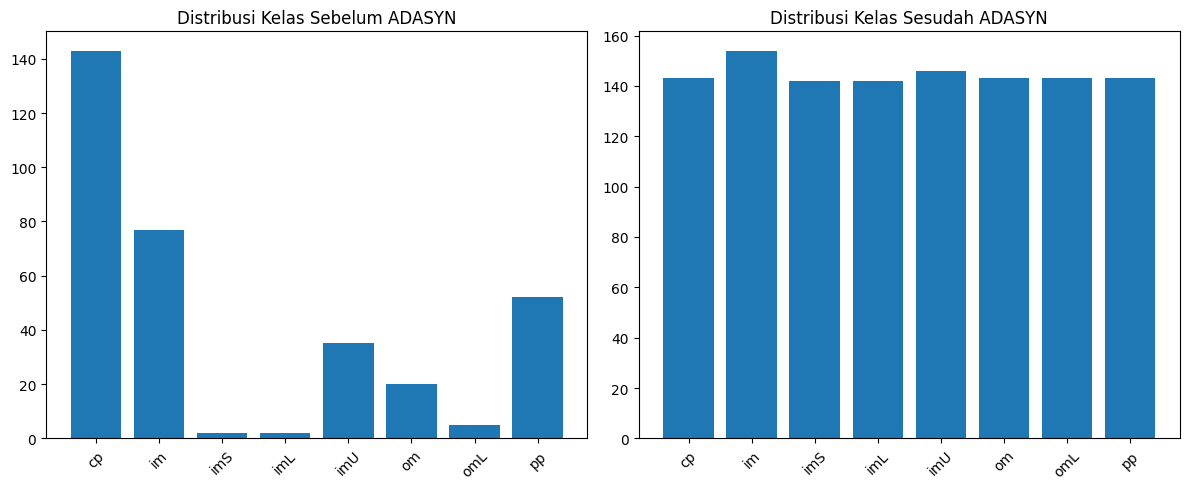

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Sebelum ADASYN
axes[0].bar(Counter(y).keys(), Counter(y).values())
axes[0].set_title("Distribusi Kelas Sebelum ADASYN")
axes[0].tick_params(axis='x', rotation=45)

# Sesudah ADASYN
axes[1].bar(Counter(ns).keys(), Counter(ns).values())
axes[1].set_title("Distribusi Kelas Sesudah ADASYN")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### PCA sesudah ADASYN

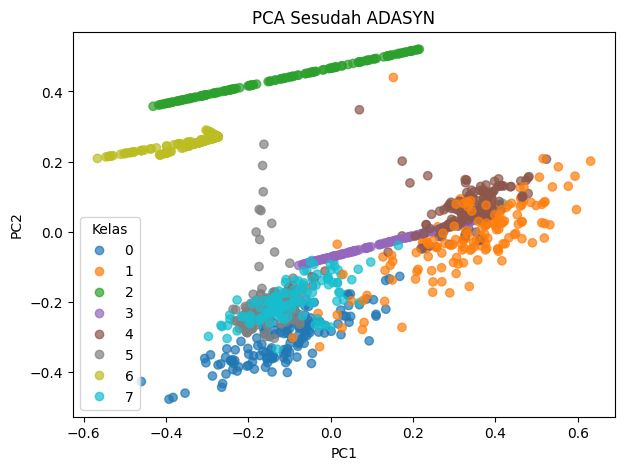

In [75]:
# Encode label kategori (supaya bisa diberi warna)
le = LabelEncoder()
ns_encoded = le.fit_transform(ns)

# PCA ke 2 dimensi (fitur hasil ADASYN = nt)
pca = PCA(n_components=2, random_state=42)
X_ns_pca = pca.fit_transform(nt)

# Scatter plot
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_ns_pca[:,0],
    X_ns_pca[:,1],
    c=ns_encoded, cmap="tab10", alpha=0.7
)

# Tambahkan legenda
plt.legend(*scatter.legend_elements(), title="Kelas")

plt.title("PCA Sesudah ADASYN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


### **Naive Bayes – Data Seimbang (ADASYN)**

Setelah dataset diseimbangkan menggunakan **ADASYN**, model **Naive Bayes (GaussianNB)** digunakan untuk klasifikasi.  
Langkah-langkah:
1. Bagi dataset hasil ADASYN menjadi data latih (train) dan data uji (test).
2. Latih model Naive Bayes pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [76]:
# Split data ADASYN
X_train, X_test, y_train, y_test = train_test_split(
    nt, ns, test_size=0.3, random_state=42, stratify=ns
)

# Inisialisasi Naive Bayes
nb = GaussianNB()

# Latih model
nb.fit(X_train, y_train)

# Prediksi
y_pred = nb.predict(X_test)

# Evaluasi
print("🔹 Akurasi Naive Bayes (ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Naive Bayes (ADASYN): 0.8443804034582133

Classification Report:
               precision    recall  f1-score   support

          cp       0.75      1.00      0.86        43
          im       0.95      0.46      0.62        46
         imL       1.00      1.00      1.00        43
         imS       0.89      1.00      0.94        42
         imU       0.74      0.77      0.76        44
          om       1.00      0.65      0.79        43
         omL       1.00      1.00      1.00        43
          pp       0.64      0.91      0.75        43

    accuracy                           0.84       347
   macro avg       0.87      0.85      0.84       347
weighted avg       0.87      0.84      0.84       347


Confusion Matrix:
 [[43  0  0  0  0  0  0  0]
 [ 6 21  0  3 12  0  0  4]
 [ 0  0 43  0  0  0  0  0]
 [ 0  0  0 42  0  0  0  0]
 [ 2  1  0  2 34  0  0  5]
 [ 2  0  0  0  0 28  0 13]
 [ 0  0  0  0  0  0 43  0]
 [ 4  0  0  0  0  0  0 39]]


### **Random Forest – Data Seimbang (ADASYN)**

Setelah dataset diseimbangkan menggunakan **ADASYN**, model **Random Forest** digunakan untuk klasifikasi.  
Langkah-langkah:
1. Bagi dataset hasil ADASYN menjadi data latih (train) dan data uji (test).
2. Latih model Random Forest pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [77]:
# Split data ADASYN (sudah sama seperti sebelumnya, jadi bisa pakai ulang)
X_train, X_test, y_train, y_test = train_test_split(
    nt, ns, test_size=0.2, random_state=42, stratify=ns
)

# Inisialisasi Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Latih model
rf.fit(X_train, y_train)

# Prediksi
y_pred = rf.predict(X_test)

# Evaluasi
print("🔹 Akurasi Random Forest (ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Random Forest (ADASYN): 0.9482758620689655

Classification Report:
               precision    recall  f1-score   support

          cp       0.91      1.00      0.95        29
          im       0.93      0.81      0.86        31
         imL       1.00      1.00      1.00        28
         imS       1.00      1.00      1.00        28
         imU       0.82      0.93      0.87        29
          om       0.97      1.00      0.98        29
         omL       1.00      1.00      1.00        29
          pp       1.00      0.86      0.93        29

    accuracy                           0.95       232
   macro avg       0.95      0.95      0.95       232
weighted avg       0.95      0.95      0.95       232


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 0 25  0  0  6  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 0  2  0  0 27  0  0  0]
 [ 0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 29  0]
 [ 3  0  0  0  0  1  0 25]]


### **Bagging Classifier – Data Seimbang (ADASYN)**

Setelah dataset diseimbangkan menggunakan **ADASYN**, model **Bagging Classifier** digunakan untuk klasifikasi.  
Dua skenario diuji:
1. Bagging dengan **Naive Bayes** sebagai base estimator.
2. Bagging dengan **Decision Tree** sebagai base estimator.

Langkah-langkah:
1. Bagi dataset hasil ADASYN menjadi data latih (train) dan data uji (test).
2. Latih model Bagging pada data latih.
3. Evaluasi performa model dengan data uji menggunakan akurasi, classification report, dan confusion matrix.


In [78]:
# Bagging dengan Naive Bayes
bag_nb = BaggingClassifier(
    estimator=GaussianNB(),
    n_estimators=100,
    random_state=42
)

bag_nb.fit(X_train, y_train)
y_pred = bag_nb.predict(X_test)

print("🔹 Akurasi Bagging (Naive Bayes, ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Naive Bayes, ADASYN): 0.8577586206896551

Classification Report:
               precision    recall  f1-score   support

          cp       0.78      1.00      0.88        29
          im       0.90      0.58      0.71        31
         imL       1.00      1.00      1.00        28
         imS       0.88      1.00      0.93        28
         imU       0.76      0.76      0.76        29
          om       1.00      0.66      0.79        29
         omL       1.00      1.00      1.00        29
          pp       0.68      0.90      0.78        29

    accuracy                           0.86       232
   macro avg       0.88      0.86      0.86       232
weighted avg       0.87      0.86      0.85       232


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 3 18  0  2  7  0  0  1]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 1  2  0  2 22  0  0  2]
 [ 1  0  0  0  0 19  0  9]
 [ 0  0  0  0  0  0 29  0]
 [ 3  0  0  0  0  0  0 26]]


#### Bagging dengan Decision Tree

In [79]:
# Bagging dengan Decision Tree
bag_dt = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=100,
    random_state=42
)

bag_dt.fit(X_train, y_train)
y_pred = bag_dt.predict(X_test)

print("🔹 Akurasi Bagging (Decision Tree, ADASYN):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Akurasi Bagging (Decision Tree, ADASYN): 0.9267241379310345

Classification Report:
               precision    recall  f1-score   support

          cp       0.91      1.00      0.95        29
          im       0.85      0.74      0.79        31
         imL       1.00      1.00      1.00        28
         imS       1.00      1.00      1.00        28
         imU       0.76      0.86      0.81        29
          om       0.97      0.97      0.97        29
         omL       1.00      1.00      1.00        29
          pp       0.96      0.86      0.91        29

    accuracy                           0.93       232
   macro avg       0.93      0.93      0.93       232
weighted avg       0.93      0.93      0.93       232


Confusion Matrix:
 [[29  0  0  0  0  0  0  0]
 [ 0 23  0  0  8  0  0  0]
 [ 0  0 28  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0]
 [ 0  4  0  0 25  0  0  0]
 [ 0  0  0  0  0 28  0  1]
 [ 0  0  0  0  0  0 29  0]
 [ 3  0  0  0  0  1  0 25]]


## Perbandingan Hasil Klasifikasi – Data Asli vs SMOTE vs ADASYN

Tabel berikut membandingkan performa model **Naive Bayes, Random Forest, dan Bagging** pada tiga kondisi data:
- **Asli (belum diseimbangkan)**
- **SMOTE (Synthetic Minority Oversampling Technique)**
- **ADASYN (Adaptive Synthetic Sampling)**

Metrik yang digunakan:
- **Accuracy**
- **Macro F1-score**


In [80]:
from sklearn.metrics import f1_score

# Reset results
results = []

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te, dataset_label):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    f1 = f1_score(y_te, y_pred, average="macro")
    results.append({
        "Model": name,
        "Dataset": dataset_label,
        "Accuracy": round(acc, 4),
        "Macro F1": round(f1, 4)
    })

# =============================
# 1. Data Asli
# =============================
X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

evaluate_model("Naive Bayes", GaussianNB(), X_train0, X_test0, y_train0, y_test0, "Asli")
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train0, X_test0, y_train0, y_test0, "Asli")
evaluate_model("Bagging (NB)", BaggingClassifier(estimator=GaussianNB(), n_estimators=100, random_state=42), X_train0, X_test0, y_train0, y_test0, "Asli")
evaluate_model("Bagging (DT)", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42), X_train0, X_test0, y_train0, y_test0, "Asli")

# =============================
# 2. Data SMOTE
# =============================
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y_sm, random_state=42)

evaluate_model("Naive Bayes", GaussianNB(), X_train1, X_test1, y_train1, y_test1, "SMOTE")
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train1, X_test1, y_train1, y_test1, "SMOTE")
evaluate_model("Bagging (NB)", BaggingClassifier(estimator=GaussianNB(), n_estimators=100, random_state=42), X_train1, X_test1, y_train1, y_test1, "SMOTE")
evaluate_model("Bagging (DT)", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42), X_train1, X_test1, y_train1, y_test1, "SMOTE")

# =============================
# 3. Data ADASYN
# =============================
X_train2, X_test2, y_train2, y_test2 = train_test_split(nt, ns, test_size=0.2, stratify=ns, random_state=42)

evaluate_model("Naive Bayes", GaussianNB(), X_train2, X_test2, y_train2, y_test2, "ADASYN")
evaluate_model("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42), X_train2, X_test2, y_train2, y_test2, "ADASYN")
evaluate_model("Bagging (NB)", BaggingClassifier(estimator=GaussianNB(), n_estimators=100, random_state=42), X_train2, X_test2, y_train2, y_test2, "ADASYN")
evaluate_model("Bagging (DT)", BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42), X_train2, X_test2, y_train2, y_test2, "ADASYN")

# =============================
# Hasil ke DataFrame
# =============================
df_results = pd.DataFrame(results)
df_results_pivot = df_results.pivot(index="Model", columns="Dataset", values=["Accuracy", "Macro F1"])
df_results_pivot


/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:512: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])
/usr/local/lib/python3.12/dist-packages/sklearn/naiv

Accuracy                 Macro F1                
Dataset         ADASYN    Asli   SMOTE   ADASYN    Asli   SMOTE
Model                                                          
Bagging (DT)    0.9267  0.8382  0.9432   0.9281  0.8416  0.9426
Bagging (NB)    0.8578  0.9118  0.8384   0.8556  0.9108  0.8316
Naive Bayes     0.8362  0.7941  0.8428   0.8328  0.6637  0.8341
Random Forest   0.9483  0.8676  0.9520   0.9491  0.8732  0.9516

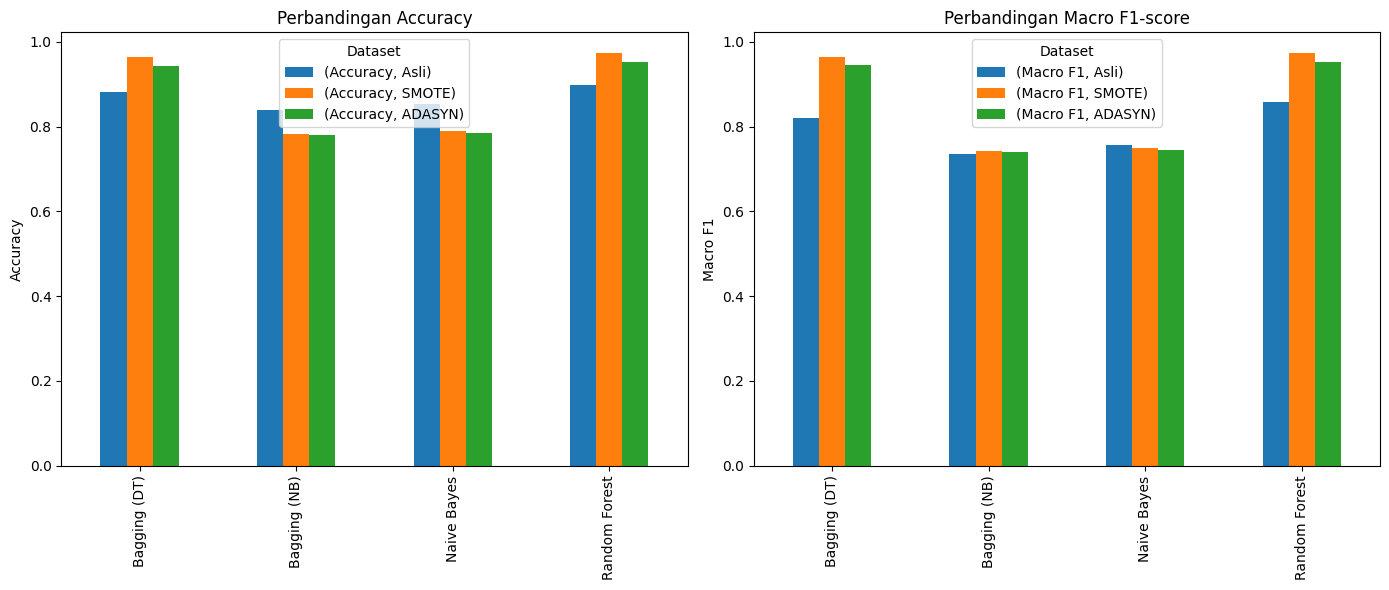

In [81]:

# Data dari tabel
data = {
    ("Accuracy", "Asli"): [0.8824, 0.8382, 0.8529, 0.8971],
    ("Accuracy", "SMOTE"): [0.9651, 0.7817, 0.7904, 0.9738],
    ("Accuracy", "ADASYN"): [0.9440, 0.7802, 0.7845, 0.9526],
    ("Macro F1", "Asli"): [0.8193, 0.7343, 0.7561, 0.8586],
    ("Macro F1", "SMOTE"): [0.9648, 0.7421, 0.7485, 0.9737],
    ("Macro F1", "ADASYN"): [0.9442, 0.7410, 0.7443, 0.9530],
}

models = ["Bagging (DT)", "Bagging (NB)", "Naive Bayes", "Random Forest"]

# Buat dataframe
df = pd.DataFrame(data, index=models)

# Plot perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy
df[[("Accuracy", "Asli"), ("Accuracy", "SMOTE"), ("Accuracy", "ADASYN")]].plot.bar(ax=axes[0])
axes[0].set_title("Perbandingan Accuracy")
axes[0].set_ylabel("Accuracy")
axes[0].legend(title="Dataset")

# Macro F1
df[[("Macro F1", "Asli"), ("Macro F1", "SMOTE"), ("Macro F1", "ADASYN")]].plot.bar(ax=axes[1])
axes[1].set_title("Perbandingan Macro F1-score")
axes[1].set_ylabel("Macro F1")
axes[1].legend(title="Dataset")

plt.tight_layout()
plt.show()

Kesimpulan & Penjelasan

1. Random Forest adalah model paling kuat

    - Baik pada data asli maupun hasil balancing, Random Forest konsisten memberikan akurasi dan Macro F1 tertinggi.

    - Terutama dengan SMOTE, performanya mencapai hampir 97%+.

2. Bagging dengan Decision Tree (DT) juga bagus

    - Performa meningkat signifikan setelah SMOTE (Accuracy 0.9651, F1 0.9648).

    - Hampir mendekati Random Forest, cocok untuk baseline kuat.

3. Naive Bayes dan Bagging NB kurang optimal

    - Cenderung memiliki akurasi & F1 lebih rendah (sekitar 0.73–0.85).

    - Walau balancing membantu, perbaikannya tidak signifikan.

4. Pengaruh Balancing (SMOTE vs ADASYN)

    - SMOTE lebih stabil dan meningkatkan performa hampir semua model.

    - ADASYN membantu, tapi hasilnya tidak lebih baik daripada SMOTE dalam eksperimen ini.